# Setup

In [1]:
import os
import sys

import sklearn
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
sns.set_theme(style="ticks")

%config Completer.use_jedi = False

# Voting classifiers

**Hard Voting:** Take a bunch of classifiers and let them vote for the classification of an instance. This ususally performes better then the best individual classifier. This works even when all classifiers are weak-learnes, then the ensemble acts as a strong learner IF the classifiers are sufficiently diverse.

*Law of large number* 

Requirement: Independend calssifiers with uncorellated errors. Trained on the same data they are likely to make the same errors. A way to overcome this is to use different algorithms.

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

<AxesSubplot:>

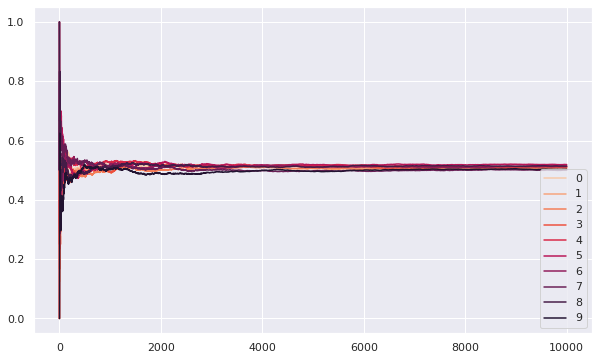

In [3]:
sns.set(rc={"figure.figsize":(10, 6)})
sns.lineplot(
    data=cumulative_heads_ratio,
    dashes=False,
    palette=sns.color_palette("rocket_r", 10),
    #height=10,
)

Moon data set

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Bagging and Pasting

Use the same training algorithm but on different sampled subsets of the data. When random samping is performed with replacement, it is called **bagging**, whitout replacement is it called **pasting**.

Form: https://link.springer.com/article/10.1007/BF00058655
    
Bagging predictors is a method for generating multiple versions of a predictor and using these to get an aggregated predictor. The aggregation averages over the versions when predicting a numerical outcome and does a plurality vote when predicting a class. The multiple versions are formed by making bootstrap replicates of the learning set and using these as new learning sets. Tests on real and simulated data sets using classification and regression trees and subset selection in linear regression show that bagging can give substantial gains in accuracy. The vital element is the instability of the prediction method. If perturbing the learning set can cause significant changes in the predictor constructed, then bagging can improve accuracy.    

Each individual predictor has a higher bias and variance then a big one trained on the original set. Thier aggregation has a similar bias but lower variance then a big one trained on the original set.

## Bagging and Pasting in Scikit-Leran

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [6]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [7]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [8]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

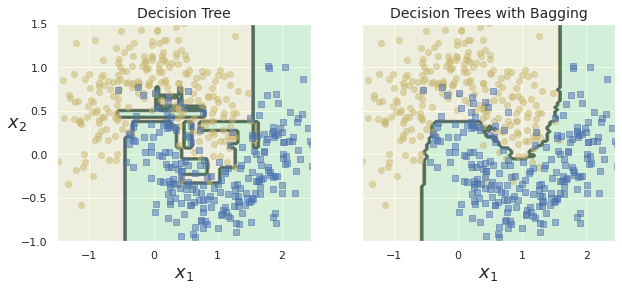

In [9]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

# Feature importance i.e. Random Forest

#### Out of the bag evalutation

In bagging the predictor samples a subset of the whole data set an trains on it. It does not see the other not sampled instances and can thus use them for evaluation.

#### Random patches and Random subspaces
The BaggingClassifier supports sampling of featuers as well. Here not all features are used all the time but subsets get sampled. This reduces the dimensionality.
This increases the training diversity => A bit more bias but a lower variance.

#### Random Forest
An ensemble of decision trees, usually trained via the bagging methode and max-samples. The RandomForestClassifier introduces extra randomness by not always seraching for the best feature to split the node but the best of a random subset of nodes.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

#### Extra-Trees
Extra layer of randomness by not only finding the best feature among a random subset but also a lower threshold. Reduces the training time as the lower threshold makes it easier to find the feature to split the node along.

#### Feature importance

Fetch MNIST data set. Apply RnadomForestClassifier on it with 100 estimators. Then analyse the importance of each pixel (Information value?).

In [11]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


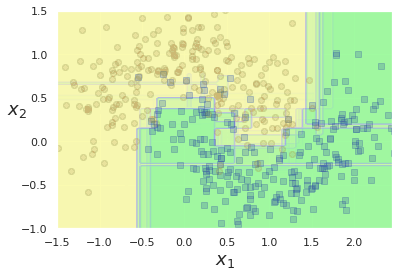

In [12]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

In [13]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [14]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [15]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

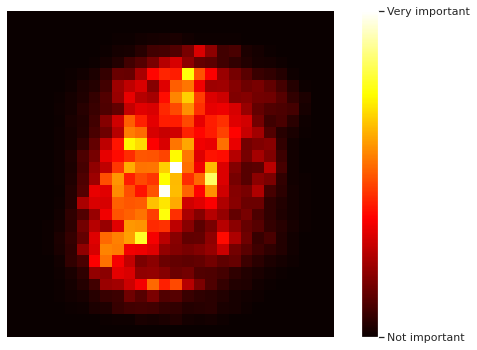

In [16]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

# Boosting

Refers to: Every ensemble methode that can combine several weak-learners into a strong-one.

#### AdaBoost
On each new predictor, give a higher focus to the values the former predictor underfitted, by increasing thier relative weight. *#sequential learning*.
It can not be parallelized. Each predictor has different weights. 

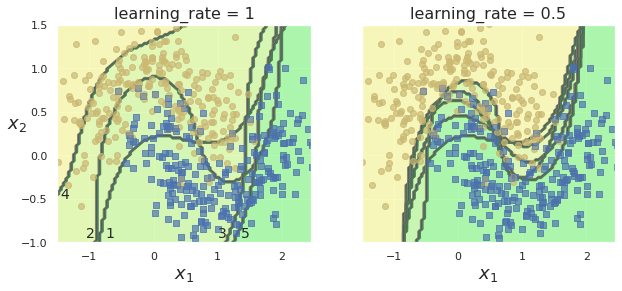

In [19]:
from sklearn.svm import SVC

m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

#### Gradient boosting
Like AdaBoosting, it is sequential with each predictor building on its former one and correcting it. Difference is that Gradient boosting tries to fit to the residual error the previouse predictor made. 
This works with regression and classification tasks. 

In [20]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [21]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [22]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [23]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [24]:
X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

y_pred

array([0.75026781])

In [25]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

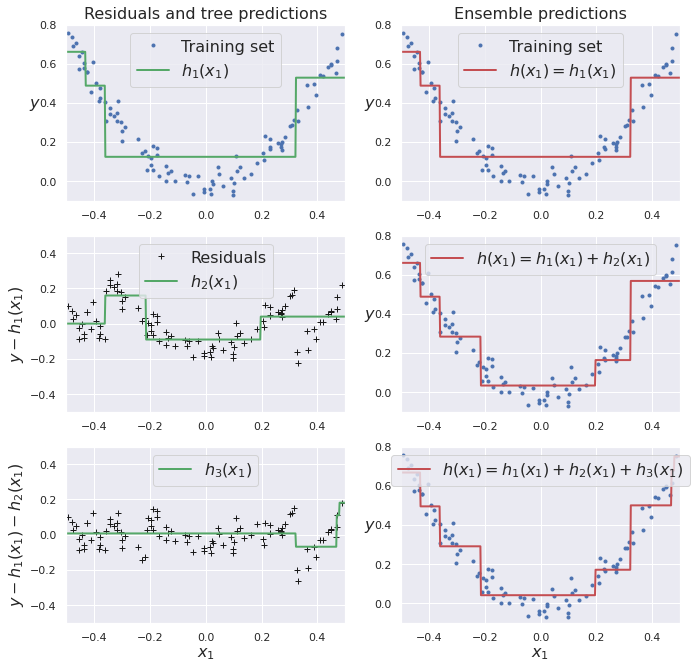

In [26]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

**Example explanation**
First row is the first tree so no prior residuals. The 2nd row is trained on the residuals (errors)of the 1st one and so on.

**Overfitting** Problem could be overfitting and have to many trees (Learning rate to high).

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [28]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

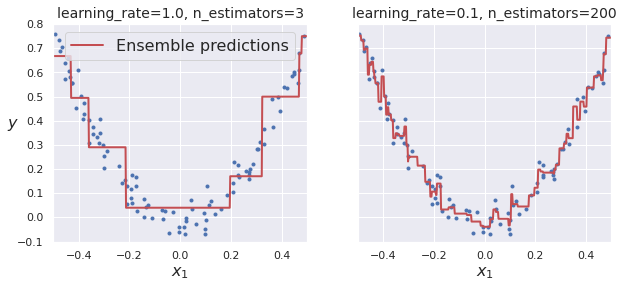

In [29]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

**Overfitting solution: early stopping**

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [31]:
min_error = np.min(errors)

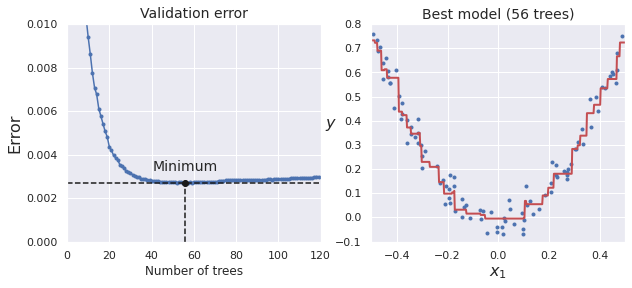

In [32]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

Early stopping with some patience (interrupts training only after there's no improvement for 5 epochs):

In [34]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping
            
print(gbrt.n_estimators)

61


**Stochastic Gradient Boosting**: Same methode just use a hyper-parameter to randomly sample subset of training data (different one each time). => more diversity => higher bias and less variance.

# Stacking
Instead of letting the different predictors vote we stack another predictor behind thier output and train it on thier outputs.